---
jupyter: python3
execute:
  cache: true
---

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay, f1_score, classification_report
from joblib import Parallel, delayed

In [ ]:
DATA_PATH = "../../data/"
MVG_FILE = "subway_only_dedup.parquet"
EVENTS_FILE = "events.csv"
HOLIDAYS_FILE = "public_holiday.csv"
ALLIANZ_FILE = "allianz_arena_events.csv"

In [ ]:
def load_data(path, mvg_file, events_file, holidays_file, allianz_file):
    mvg_data = pd.read_parquet(path + mvg_file)
    events_df = pd.read_csv(path + events_file, parse_dates=['start_date', 'end_date'])
    public_holiday_df = pd.read_csv(path + holidays_file, parse_dates=['date'])
    allianz_arena_df = pd.read_csv(path + allianz_file, parse_dates=['date'])
    return mvg_data, events_df, public_holiday_df, allianz_arena_df

mvg_data_orig, events_df, public_holiday_df, allianz_arena_df = load_data(
    DATA_PATH, MVG_FILE, EVENTS_FILE, HOLIDAYS_FILE, ALLIANZ_FILE
)

In [ ]:
mvg_data = mvg_data_orig

mvg_data = mvg_data.drop(columns=['transportType', 'realtimeDepartureTime', 'timestamp'])
mvg_data = mvg_data[mvg_data.realtime]
mvg_data['onTime'] = mvg_data['delayInMinutes'] == 0

mvg_datetime = pd.to_datetime(mvg_data['plannedDepartureTime']).dt
mvg_data['plannedDepartureTime_dt'] = pd.to_datetime(mvg_data['plannedDepartureTime'])

#mvg_data['hourOfDay'] = mvg_datetime.hour

mvg_data['minuteOfDay'] = mvg_datetime.hour * 60 + mvg_datetime.minute
# encode minute of day as 23:00 and 00:00 are far apart but close in reality
mvg_data['minuteSin'] = np.sin(2 * np.pi * mvg_data['minuteOfDay'] / 1440)
mvg_data['minuteCos'] = np.cos(2 * np.pi * mvg_data['minuteOfDay'] / 1440)


mvg_data['dayOfWeek'] = mvg_datetime.day_of_week # Monday=0, Sunday=6
#mvg_data['dayOfYear'] = mvg_datetime.day_of_year

mvg_data['isRushHour'] = mvg_datetime.hour.between(7, 9) | mvg_datetime.hour.between(16, 18)
mvg_data['isWeekend'] = mvg_data['dayOfWeek'] >= 5 # Saturday=5, Sunday=6

# remove negative delay for bucketing
mvg_data = mvg_data[mvg_data['delayInMinutes'] >= 0]

# only use u6
mvg_data = mvg_data[mvg_data['label'] == 'U6']

# include events
mvg_data['isMajorEvent'] = False
for index, event in events_df.iterrows():
    event_mask = (
        (mvg_data['plannedDepartureTime_dt'].dt.date >= event['start_date'].date()) &
        (mvg_data['plannedDepartureTime_dt'].dt.date <= event['end_date'].date())
    )
    mvg_data.loc[event_mask, 'isMajorEvent'] = True
print("\nEvent day departures vs. normal day departures:")
print(mvg_data['isMajorEvent'].value_counts())


# set if public holiday is true
holiday_dates = set(public_holiday_df['date'].dt.date)
mvg_data['isHoliday'] = mvg_data['plannedDepartureTime_dt'].dt.date.isin(holiday_dates)
print("\nHoliday departures vs. normal day departures:")
print(mvg_data['isHoliday'].value_counts())

# include allianz arena events
allianz_arena_dates = set(allianz_arena_df['date'].dt.date)
mvg_data['isAllianzArenaEvent'] = mvg_data['plannedDepartureTime_dt'].dt.date.isin(allianz_arena_dates)
print("\nAllianz Arena Event departures vs. normal day departures:")
print(mvg_data['isAllianzArenaEvent'].value_counts())

bins = [float('-inf'), 2, np.inf]
labels = ['On Time', 'Delayed']
mvg_data['delayCategory'] = pd.cut(mvg_data['delayInMinutes'], bins=bins, labels=labels)

print("New binary class distribution:\n", mvg_data['delayCategory'].value_counts())


Event day departures vs. normal day departures:
isMajorEvent
False    3204709
True      249221
Name: count, dtype: int64

Holiday departures vs. normal day departures:
isHoliday
False    3386613
True       67317
Name: count, dtype: int64

Allianz Arena Event departures vs. normal day departures:
isAllianzArenaEvent
False    3153279
True      300651
Name: count, dtype: int64
New binary class distribution:
 delayCategory
On Time    3371137
Delayed      82793
Name: count, dtype: int64


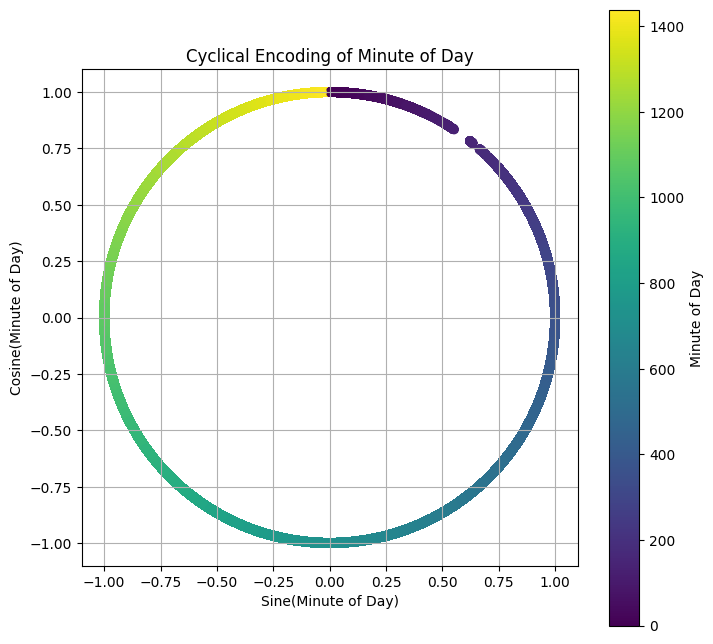

In [ ]:
plt.figure(figsize=(8, 8))
scatter = plt.scatter(
    mvg_data['minuteSin'],
    mvg_data['minuteCos'],
    c=mvg_data['minuteOfDay'], # Color points by the original minute of the day
    cmap='viridis'            # Use a nice color map
)

plt.gca().set_aspect('equal', adjustable='box')

plt.title('Cyclical Encoding of Minute of Day')
plt.xlabel('Sine(Minute of Day)')
plt.ylabel('Cosine(Minute of Day)')

# Add a colorbar to show what the colors mean
cbar = plt.colorbar(scatter)
cbar.set_label('Minute of Day')

plt.grid(True)
plt.show()

In [ ]:
mvg_data.sample(5)

,station,plannedDepartureTime,realtime,delayInMinutes,label,destination,onTime,plannedDepartureTime_dt,minuteOfDay,minuteSin,minuteCos,dayOfWeek,isRushHour,isWeekend,isMajorEvent,isHoliday,isAllianzArenaEvent,delayCategory
20951859,de:09162:540,2024-08-20 15:19:00+00:00,True,0,U6,"Garching, Forschungszentrum",True,2024-08-20 15:19:00+00:00,919,-0.763232,-0.646124,1,False,False,False,False,False,On Time
20987629,de:09162:540,2024-12-07 12:01:00+00:00,True,0,U6,Klinikum Großhadern,True,2024-12-07 12:01:00+00:00,721,-0.004363,-0.999990,5,False,True,False,False,True,On Time
16155415,de:09162:50,2025-06-27 12:32:00+00:00,True,7,U6,Kieferngarten,False,2025-06-27 12:32:00+00:00,752,-0.139173,-0.990268,4,False,False,False,False,False,Delayed
10492385,de:09162:1530,2024-08-22 09:18:00+00:00,True,0,U6,"Garching, Forschungszentrum",True,2024-08-22 09:18:00+00:00,558,0.649448,-0.760406,3,True,False,False,False,False,On Time
12791813,de:09162:470,2025-05-14 15:59:00+00:00,True,0,U6,Brudermühlstraße,True,2025-05-14 15:59:00+00:00,959,-0.863836,-0.503774,2,False,False,False,False,False,On Time


In [ ]:
features = mvg_data.drop(['delayInMinutes', 'onTime', 'plannedDepartureTime', 'plannedDepartureTime_dt', 'delayCategory', 'realtime', 'minuteOfDay'], axis=1)
target = mvg_data['delayCategory']

features_encoded = pd.get_dummies(features, columns=['station', 'label', 'destination'])

print(f"Total rows in the full dataset: {len(features_encoded)}")

X_sample, _, y_sample, _ = train_test_split(features_encoded, target, train_size=5_000, random_state=0, stratify=target)
X_train_sample, X_test_sample, y_train_sample, y_test_sample = train_test_split(X_sample, y_sample, test_size=0.3, random_state=0)
X_val_sample, X_test_sample, y_val_sample, y_test_sample = train_test_split(X_test_sample, y_test_sample, test_size=0.5, random_state=0)

print(f"\nSampled training set size: {len(X_train_sample)}")
print(f"Sampled validation set size: {len(X_val_sample)}")
print(f"Sampled test set size: {len(X_test_sample)}")


X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(features_encoded, target, test_size=0.3, random_state=0)
X_val_full, X_test_full, y_val_full, y_test_full = train_test_split(X_test_full, y_test_full, test_size=0.5, random_state=0)

print(f"\nFull training set size: {len(X_train_full)}")
print(f"Full validation set size: {len(X_val_full)}")
print(f"Full test set size: {len(X_test_full)}")

train_data_full = pd.concat([X_train_full, y_train_full], axis=1)
target_column_name = y_train_full.name

ontime_samples = train_data_full[train_data_full[target_column_name] == 'On Time']
delay_samples = train_data_full[train_data_full[target_column_name] == 'Delayed']

ontime_downsampled = ontime_samples.sample(n=len(delay_samples), random_state=0)

train_data_balanced = pd.concat([ontime_downsampled, delay_samples])

X_train_balanced = train_data_balanced.drop(columns=[target_column_name])
y_train_balanced = train_data_balanced[target_column_name]

print("\nOriginal full training class distribution:")
print(y_train_full.value_counts())
print("\nBalanced training class distribution:")
print(y_train_balanced.value_counts())

Total rows in the full dataset: 3453930

Sampled training set size: 3500
Sampled validation set size: 750
Sampled test set size: 750

Full training set size: 2417751
Full validation set size: 518089
Full test set size: 518090

Original full training class distribution:
delayCategory
On Time    2359877
Delayed      57874
Name: count, dtype: int64

Balanced training class distribution:
delayCategory
On Time    57874
Delayed    57874
Name: count, dtype: int64


In [ ]:
def train_and_evaluate_rf(estimators, X_train, y_train, X_val, y_val):
    """Trains a Random Forest and returns both train and validation F1-scores."""
    model = RandomForestClassifier(
        n_estimators=estimators,
        n_jobs=-1,
        random_state=0
    )
    model.fit(X_train, y_train)

    # Calculate weighted F1-score instead of accuracy
    train_pred = model.predict(X_train)
    train_f1 = f1_score(y_train, train_pred, average='weighted')

    val_pred = model.predict(X_val)
    val_f1 = f1_score(y_val, val_pred, average='weighted')

    return estimators, train_f1, val_f1

In [ ]:
train_data_sample = pd.concat([X_train_sample, y_train_sample], axis=1)
target_column_name_sample = y_train_sample.name

ontime_samples_s = train_data_sample[train_data_sample[target_column_name_sample] == 'On Time']
delay_samples_s = train_data_sample[train_data_sample[target_column_name_sample] == 'Delayed']
ontime_downsampled_s = ontime_samples_s.sample(n=len(delay_samples_s), random_state=0)
train_data_balanced_s = pd.concat([ontime_downsampled_s, delay_samples_s])

X_train_sample_balanced = train_data_balanced_s.drop(columns=[target_column_name_sample])
y_train_sample_balanced = train_data_balanced_s[target_column_name_sample]


estimators_to_test = range(10, 501, 10)

results = Parallel(n_jobs=3)(
    delayed(train_and_evaluate_rf)(n, X_train_sample_balanced, y_train_sample_balanced, X_val_sample, y_val_sample) for n in estimators_to_test
)

In [ ]:
training_results = {n: train_acc for n, train_acc, val_acc in results}
validation_results = {n: val_acc for n, train_acc, val_acc in results}

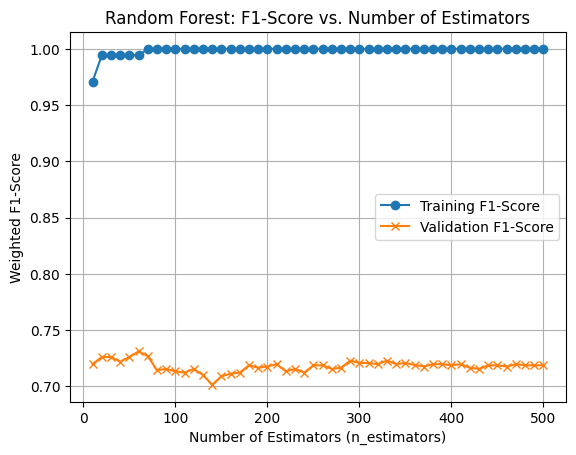

In [ ]:
params, train_f1_scores = zip(*sorted(training_results.items()))
plt.plot(params, train_f1_scores, label="Training F1-Score", marker='o')

params, val_f1_scores = zip(*sorted(validation_results.items()))
plt.plot(params, val_f1_scores, label="Validation F1-Score", marker='x')

plt.title("Random Forest: F1-Score vs. Number of Estimators")
plt.xlabel("Number of Estimators (n_estimators)")
plt.ylabel("Weighted F1-Score") # Update the y-axis label
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
best_parameter = max(validation_results, key=validation_results.get)

best_accuracy = validation_results[best_parameter]

print(f"The best parameter is: {best_parameter}")
print(f"With a validation accuracy of: {best_accuracy:.4f}")

The best parameter is: 60
With a validation accuracy of: 0.7311


In [ ]:
final_model = RandomForestClassifier(
    n_estimators=best_parameter,
    n_jobs=-1,
    verbose=1,
    random_state=0
)

print(f"Training final model on {len(X_train_balanced)} samples...")
final_model.fit(X_train_balanced, y_train_balanced)

Training final model on 115748 samples...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    1.6s finished


,n_estimators,60
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


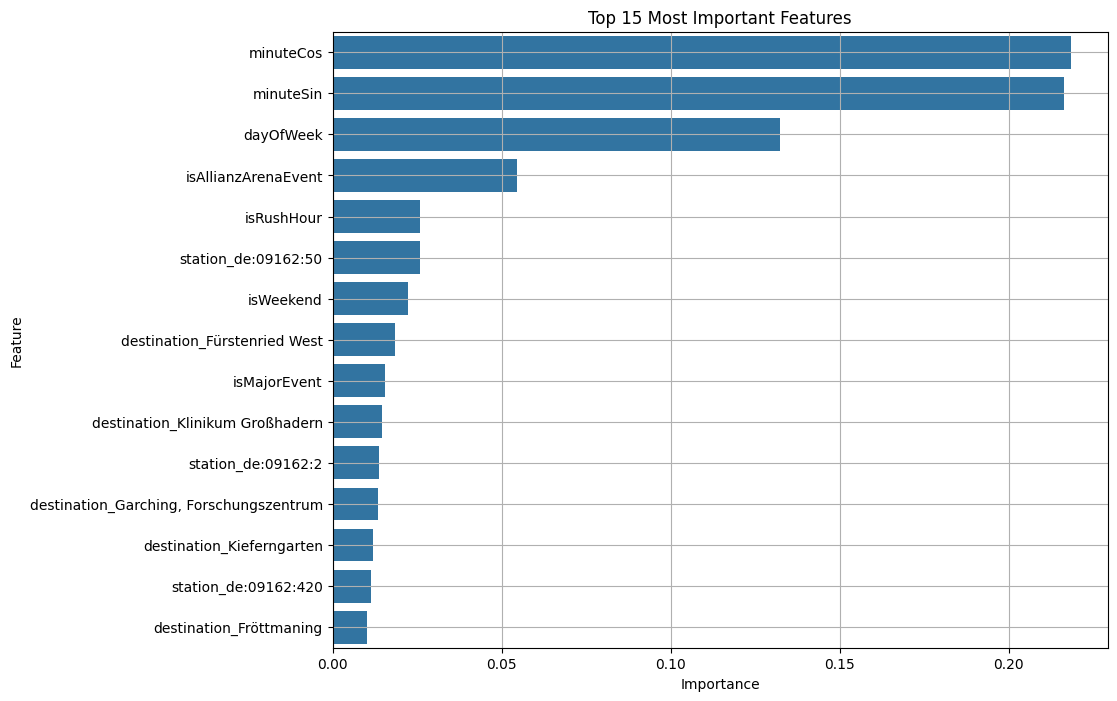

In [ ]:
importances = final_model.feature_importances_
feature_names = X_train_full.columns

feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})

feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False).head(15)

plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=feature_importance_df)
plt.title('Top 15 Most Important Features')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.grid(True)
plt.show()

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done  60 out of  60 | elapsed:    1.4s finished


Classification Report:
              precision    recall  f1-score   support

     Delayed       0.06      0.76      0.12     12517
     On Time       0.99      0.73      0.84    505573

    accuracy                           0.73    518090
   macro avg       0.53      0.74      0.48    518090
weighted avg       0.97      0.73      0.82    518090



[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done  60 out of  60 | elapsed:    1.3s finished


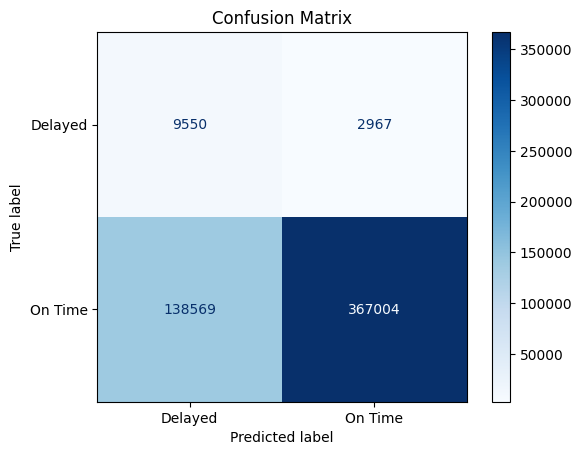

In [ ]:
y_pred = final_model.predict(X_test_full)

print("Classification Report:")
print(classification_report(y_test_full, y_pred))

disp = ConfusionMatrixDisplay.from_estimator(
    final_model,
    X_test_full,
    y_test_full,
    cmap=plt.cm.Blues
)
disp.ax_.set_title('Confusion Matrix')
plt.show()